In [1]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

P-value: 0.0

As the p-value 0.0 is smaller than 0.05, we can reject the Null-Hypothesis that the model that does not consider the acquisition and the budget describes the data as well as the one that does. Therefore there is significant difference within acquisition and the budget.

P-values adjusted by tukey method for family of 36 estimates
The best performing acquisition in budget-class 0_9 is ProbabilityOfImprovement, but ['ExpectedImprovement', 'qExpectedImprovement', 'qProbabilityOfImprovement', 'qSimpleRegret', 'qUpperConfidenceBound', 'randomSearch'] are only insignificantly worse.

The best performing acquisition in budget-class 9_20 is ExpectedImprovement, but ['ProbabilityOfImprovement', 'UpperConfidenceBound', 'qExpectedImprovement', 'qKnowledgeGradient', 'qSimpleRegret', 'qUpperConfidenceBound'] are only insignificantly worse.

The best performing acquisition in budget-class 20_35 is qExpectedImprovement, but ['ExpectedImprovement', 'UpperConfidenceBound', 'qSimpleRegret'

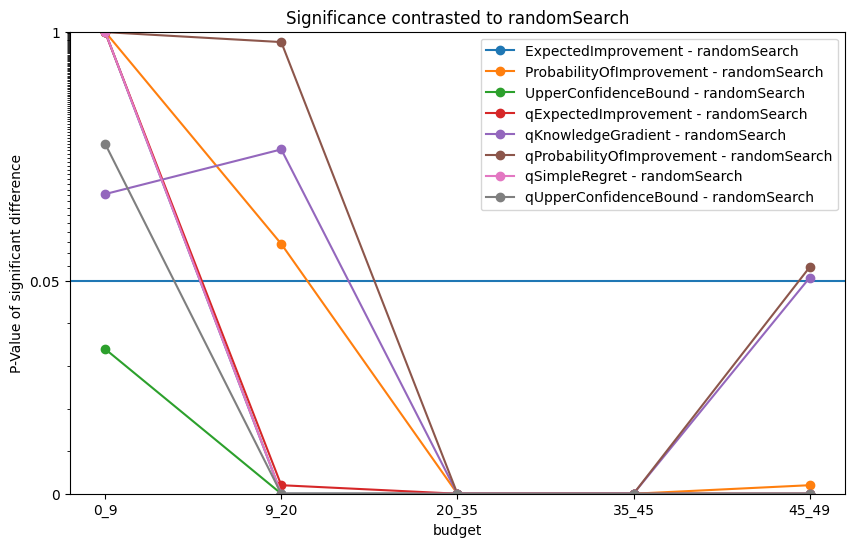

({'chi_square': 161.58590545505285, 'df': 32, 'p': 0.0},
 (                  acquisition budget_bins  Estimate  2.5_ci  97.5_ci     SE     DF
  1         ExpectedImprovement         0_9    15.174  -3.916   34.264  6.077  3.070
  2    ProbabilityOfImprovement         0_9    14.925  -4.166   34.015  6.077  3.070
  3        UpperConfidenceBound         0_9    15.680  -3.410   34.770  6.077  3.070
  4        qExpectedImprovement         0_9    15.219  -3.871   34.310  6.077  3.070
  5          qKnowledgeGradient         0_9    15.580  -3.511   34.670  6.077  3.070
  6   qProbabilityOfImprovement         0_9    15.216  -3.874   34.306  6.077  3.070
  7               qSimpleRegret         0_9    15.024  -4.066   34.115  6.077  3.070
  8       qUpperConfidenceBound         0_9    15.526  -3.564   34.617  6.077  3.070
  9                randomSearch         0_9    15.047  -4.043   34.138  6.077  3.070
  10        ExpectedImprovement        9_20     7.274 -11.817   26.365  6.076  3.070
  11   P

In [2]:
# Second Analysis: Analyse performance of acquisition functions over all benchmarks binned by trainingrounds,
# i.e. performance in the first 8, the next 12, the next 15, the next 10 and the final 5 rounds.
# Does not print the results, only shows plots.
conduct_analysis(
    data.loc[data["benchmark"]!="NN_HPO_Bench"],
    "mean",
    "acquisition",
    "benchmark",
    bin_id="budget",
    bins=[9, 20, 35, 45],
    summarize=False,
    show_plots=False,
    significance_plot="randomSearch"
)